# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2023-spring@googlegroups.com

Slide:    [Link](https://docs.google.com/presentation/d/18LkR8qulwSbi3SVoLl1XNNGjQQ_qczs_35lrJWOmHCk/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/t/c76950cc460140eba30a576ca7668d28)

# Set up the environment


## Package installation

In [1]:
# Training progress bar
!pip install  qqdm

  Preparing metadata (setup.py) ... done
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6488 sha256=c7ff84bb449b470a8497fbb2a230d9e79ced973b4c1d2c9074cd565c345e85b4
  Stored in directory: /root/.cache/pip/wheels/64/fe/88/5810e19e4369508bfce50d8dcddcf109787906cdf6016cb70f
Successfully built qqdm


## Downloading data

In [2]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh |  bash
!apt-get install -y --allow-unauthenticated git-lfs

Detected operating system as Ubuntu/focal.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.0.9
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 88 not upgraded.
Need to get 7419 kB of archives.
After this operation, 4936 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu focal/main amd64 git-lfs amd64 3.3.0 [7419 kB]
Fetched 7419 kB in 1s (6677 kB/s)
(Reading database ... 111522 files and directories current

In [3]:
!git clone https://github.com/chiyuanhsiao/ml2023spring-hw8

Cloning into 'ml2023spring-hw8'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 2), reused 8 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), done.
Resolving deltas: 100% (2/2), done.


In [4]:
%cd /kaggle/working/ml2023spring-hw8
!git lfs install
!git lfs pull

/kaggle/working/ml2023spring-hw8
Updated Git hooks.
Git LFS initialized.


# Import packages

In [5]:
import random
import numpy as np
import torch
import os
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, Dataset
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW
from torchvision import transforms as transforms, utils
from torchvision.utils import save_image
import torchvision.models as models
from qqdm import qqdm, format_str
from tqdm.auto import tqdm
import pandas as pd
import cv2
import gc
from PIL import Image
from matplotlib import pyplot as plt

# Loading data

In [6]:
train = np.load('/kaggle/working/ml2023spring-hw8/trainingset.npy', allow_pickle=True)[:,8:56,8:56,:]
test = np.load('/kaggle/working/ml2023spring-hw8/testingset.npy', allow_pickle=True)[:,8:56,8:56,:]

print(train.shape)
print(test.shape)

(100000, 48, 48, 3)
(19636, 48, 48, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [8]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(42)

# Autoencoder

In [9]:
class conv_autoencoder(nn.Module):
    def __init__(self):             
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1), 
            nn.ReLU(),
        )   # Hint:  dimension of latent space can be adjusted
        self.fce = nn.Sequential(
            nn.Flatten(1, 3),                          
            nn.Linear(48*6*6, 48),                     
            nn.ReLU(),
        ) 
        self.fcd = nn.Sequential(
            nn.Linear(48, 48*6*6),                     
            nn.ReLU(),
            nn.Unflatten(1, (48,6,6)),                         
        ) 
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.fce(x)
        x = self.fcd(x)
        x = self.decoder(x)
        return x

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [10]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)
            
        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [11]:
# Training hyperparameters
num_epochs = 30
batch_size = 128
learning_rate = 1e-3
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=10, T_mult=3, eta_min=0) 

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'cnn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'cnn': conv_autoencoder()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training loop

 Iters    Elapsed Time      Speed                                               
 0/30           -             -                                                 
Description   0.0% |                                                           |

image in epoch:  0


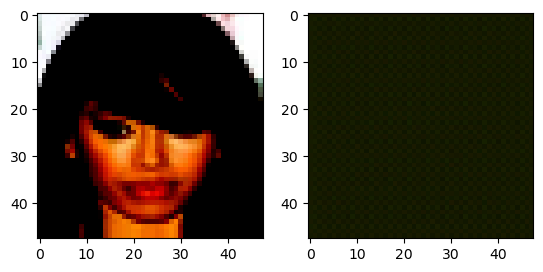

 Iters    Elapsed Time      Speed    epoch   loss                               
 1/30   00:00:27<00:13:24  0.04it/s  1/30   0.0875                              
Description   3.3% |█                                                          | Iters    Elapsed Time      Speed    epoch   loss                               
 2/30   00:00:49<00:11:33  0.04it/s  2/30   0.0550                              
Description   6.7% |███                                                        | Iters    Elapsed Time      Speed    epoch   loss                               
 3/30   00:01:12<00:10:49  0.04it/s  3/30   0.0524                              
Description  10.0% |█████                                                      | Iters    Elapsed Time      Speed    epoch   loss                               
 4/30   00:01:34<00:10:13  0.04it/s  4/30   0.0510                              
Description  13.3% |███████                                                    | Iters    Elapsed Time      Spee

image in epoch:  5


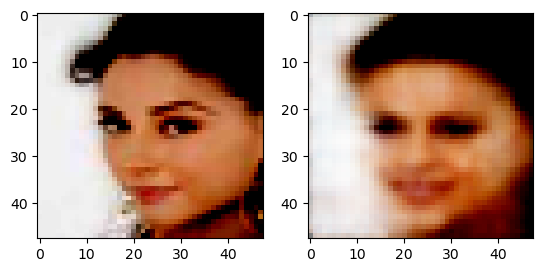

 Iters    Elapsed Time      Speed    epoch   loss                               
 6/30   00:02:18<00:09:14  0.04it/s  6/30   0.0493                              
Description  20.0% |███████████                                                | Iters    Elapsed Time      Speed    epoch   loss                               
 7/30   00:02:41<00:08:49  0.04it/s  7/30   0.0487                              
Description  23.3% |█████████████                                              | Iters    Elapsed Time      Speed    epoch   loss                               
 8/30   00:03:03<00:08:25  0.04it/s  8/30   0.0482                              
Description  26.7% |███████████████                                            | Iters    Elapsed Time      Speed    epoch   loss                               
 9/30   00:03:25<00:08:00  0.04it/s  9/30   0.0477                              
Description  30.0% |█████████████████                                          | Iters    Elapsed Time      Spee

image in epoch:  10


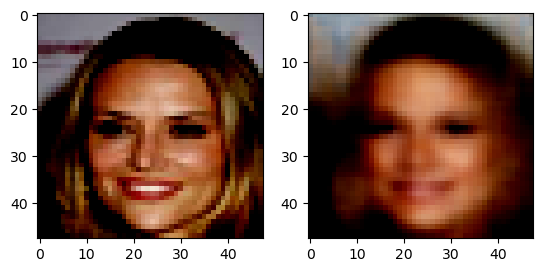

 Iters    Elapsed Time      Speed    epoch   loss                               
 11/30  00:04:11<00:07:13  0.04it/s  11/30  0.0469                              
Description  36.7% |█████████████████████                                      | Iters    Elapsed Time      Speed    epoch   loss                               
 12/30  00:04:33<00:06:49  0.04it/s  12/30  0.0466                              
Description  40.0% |███████████████████████                                    | Iters    Elapsed Time      Speed    epoch   loss                               
 13/30  00:04:55<00:06:26  0.04it/s  13/30  0.0464                              
Description  43.3% |█████████████████████████                                  | Iters    Elapsed Time      Speed    epoch   loss                               
 14/30  00:05:17<00:06:03  0.04it/s  14/30  0.0461                              
Description  46.7% |███████████████████████████                                | Iters    Elapsed Time      Spee

image in epoch:  15


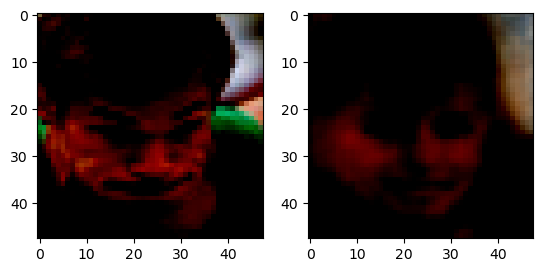

 Iters    Elapsed Time      Speed    epoch   loss                               
 16/30  00:06:02<00:05:16  0.04it/s  16/30  0.0458                              
Description  53.3% |███████████████████████████████                            | Iters    Elapsed Time      Speed    epoch   loss                               
 17/30  00:06:24<00:04:54  0.04it/s  17/30  0.0456                              
Description  56.7% |█████████████████████████████████                          | Iters    Elapsed Time      Speed    epoch   loss                               
 18/30  00:06:46<00:04:31  0.04it/s  18/30  0.0455                              
Description  60.0% |███████████████████████████████████                        | Iters    Elapsed Time      Speed    epoch   loss                               
 19/30  00:07:08<00:04:08  0.04it/s  19/30  0.0453                              
Description  63.3% |█████████████████████████████████████                      | Iters    Elapsed Time      Spee

image in epoch:  20


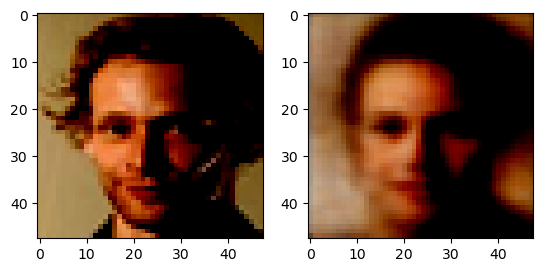

 Iters    Elapsed Time      Speed    epoch   loss                               
 21/30  00:07:53<00:03:22  0.04it/s  21/30  0.0451                              
Description  70.0% |█████████████████████████████████████████                  | Iters    Elapsed Time      Speed    epoch   loss                               
 22/30  00:08:15<00:03:00  0.04it/s  22/30  0.0450                              
Description  73.3% |███████████████████████████████████████████                | Iters    Elapsed Time      Speed    epoch   loss                               
 23/30  00:08:37<00:02:37  0.04it/s  23/30  0.0449                              
Description  76.7% |█████████████████████████████████████████████              | Iters    Elapsed Time      Speed    epoch   loss                               
 24/30  00:08:59<00:02:14  0.04it/s  24/30  0.0448                              
Description  80.0% |███████████████████████████████████████████████            | Iters    Elapsed Time      Spee

image in epoch:  25


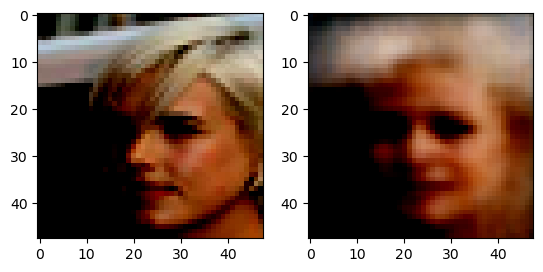

 Iters    Elapsed Time      Speed    epoch   loss                               
 26/30  00:09:43<00:01:29  0.04it/s  26/30  0.0446                              
Description  86.7% |███████████████████████████████████████████████████        | Iters    Elapsed Time      Speed    epoch   loss                               
 27/30  00:10:05<00:01:07  0.04it/s  27/30  0.0445                              
Description  90.0% |█████████████████████████████████████████████████████      | Iters    Elapsed Time      Speed    epoch   loss                               
 28/30  00:10:27<00:00:44  0.04it/s  28/30  0.0445                              
Description  93.3% |███████████████████████████████████████████████████████    | Iters    Elapsed Time      Speed    epoch   loss                               
 29/30  00:10:51<00:00:22  0.04it/s  29/30  0.0444                              
Description  96.7% |█████████████████████████████████████████████████████████  | Iters    Elapsed Time      Spee

In [12]:

best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for i, data in enumerate(train_dataloader):

        # ===================loading=====================
        img = data.float().cuda()
        # ===================forward=====================
        output = model(img.cuda())

        loss = criterion(output, img)
        
        if i == 0 and epoch%5 == 0:
            print("image in epoch: ", epoch)
            plt.subplot(1, 2, 2)
            plt.imshow(output[0].permute(1, 2, 0).cpu().detach().numpy())
            plt.subplot(1, 2, 1)
            plt.imshow(img[0].permute(1, 2, 0).cpu().detach().numpy())
            plt.show()

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        #torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [13]:
eval_batch_size = 128

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)


test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')


# load trained model
checkpoint_path = f'last_model_{model_type}.pt'
model = torch.load(checkpoint_path)
model.eval()

# prediction file 
out_file = '/kaggle/working/prediction.csv'

In [14]:
anomality = list()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        img = data.float().cuda()
        output = model(img)
        loss = eval_loss(output, img).sum([1, 2, 3])
        anomality.append(loss)

anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')

In [15]:
del train, test, train_dataset, test_dataset, train_dataloader, test_dataloader
gc.collect()

35713

In [16]:
%cd /kaggle/working
!mkdir images_train
!mkdir images_test

/kaggle/working


In [17]:
list0 = [i for i in range(100000)]
random.shuffle(list0)
list0 = list0[:10000]

In [19]:
a = np.argsort(anomality, axis=0)

new_test = np.load('/kaggle/working/ml2023spring-hw8/testingset.npy', allow_pickle=True)/255
new_test = new_test[:,8:56,8:56,:]
print(new_test.shape)

new_train = np.array([new_test[i][0] for i in a[17400:]])
new_train = new_train
print(new_train.shape)

new_train2 = np.load('/kaggle/working/ml2023spring-hw8/trainingset.npy', allow_pickle=True)[list0,:,:,:]/255
new_train2 = new_train2[:,8:56,8:56,:]
print(new_train2.shape)

%cd /kaggle/working/images_train
for i, img in enumerate(new_train):
    save_image(torch.tensor(new_train[i]).permute(2,0,1), f'img{i+1}_1.jpg')    
for i, img in enumerate(new_train2):
    save_image(torch.tensor(new_train2[i]).permute(2,0,1), f'img{i+1}_0.jpg')

%cd /kaggle/working/images_test
for i, img in enumerate(new_test):
    save_image(torch.tensor(new_test[i]).permute(2,0,1), f'img{i+1}_test.jpg')

(19636, 48, 48, 3)
(2236, 48, 48, 3)
(10000, 48, 48, 3)
/kaggle/working/images_train
/kaggle/working/images_test


In [20]:
del new_test, new_train, new_train2
gc.collect()

62

### ResNet50

In [ ]:
#REF: hw3 ref-code

In [21]:
_exp_name = "new_method"

In [23]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

valid_tfm = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((48, 48)),
    # You may add some transforms here.
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0),
    #transforms.RandomPerspective(distortion_scale=0.6, p=0.6),
    #transforms.RandomAffine(degrees=(-30, 30), translate=(0, 0.4), scale=(0.8, 1.5)),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

In [24]:
class FoodDataset2(Dataset):

    def __init__(self,path1,mode = ''):
        super(FoodDataset2).__init__()
        f_list = [os.path.join(path1,x) for x in os.listdir(path1) if x.endswith(".jpg")]
        random.seed(42)
        random.shuffle(f_list)
        self.mode = mode
            
        if mode == 'train':  
            self.files = f_list[:11000]
            
            self.transform = train_tfm
        elif mode == 'valid':  
            self.files = f_list[11000:]
            
            self.transform = valid_tfm

  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        label = int(fname[-5])
        
        label_list = torch.zeros(3)
        label_list[label] = 1
        label_list[2] = label

        return im,label_list

In [25]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None, mode = ''):
        super(FoodDataset).__init__()
        self.path = path
        list0 = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        list1 = [f.split("/")[-1][3:len(f.split("/")[-1])-9] for i, f in enumerate(list0)]
        list2 = [i for i in range(len(list0))]
        for i in range(len(list0)):
            list2[int(list1[i])-1] = list0[i]
        self.files = list2
        self.mode = mode
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        
        if self.mode == 'test':
            ims = [test_tfm(im)]
            ims += [train_tfm(im) for _ in range(5)]
            label = -1 # test has no label
            return torch.stack(ims), label


In [26]:
from torchvision.models import resnet50

In [27]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = resnet50(num_classes = 2).to(device)
#print(model)

# The number of batch size.
batch_size = 128

# The number of training epochs.
n_epochs = 100

# If no improvement in 'patience' epochs, early stop.
patience = 30

# For the classification task, we use cross-entropy as the measurement of performance.
#criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

lr_lambda = lambda epoch: 0.08 * epoch if epoch < 10 else (1-(0.95*(epoch>25))-(0.0495*(epoch>50)))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [28]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset2("/kaggle/working/images_train", mode='train')
valid_set = FoodDataset2("/kaggle/working/images_train", mode='valid')

print("train_set:",len(train_set.files),"valid_set:",len(valid_set.files))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

train_set: 11000 valid_set: 1236


In [ ]:
#REF: https://course18.fast.ai/lessons/lesson9.html
#REF:https://openaccess.thecvf.com/content_CVPR_2019/papers/Cui_Class-Balanced_Loss_Based_on_Effective_Number_of_Samples_CVPR_2019_paper.pdf

In [29]:
import torch.nn.functional as F

def focal_loss(logits, labels, alpha, gamma):
    
    bce_loss = F.binary_cross_entropy_with_logits(input=logits, target=labels, reduction="none")
    
    t0 = torch.zeros(2,logits.shape[0],2).to(device)
    t0[0] = -1.0 * logits
    
    f1 = torch. logsumexp(t0, dim=0)
    f2 = - gamma * f1
    f3 = -gamma * labels * logits

    modulator = torch.exp(f3 + f2)
    modulator = torch.nan_to_num(modulator, nan=1)
    
    loss = modulator * bce_loss
    
    weighted_loss = alpha * loss
    loss = torch.sum(weighted_loss)
    loss /= torch.sum(labels)
    
    
    return loss

In [30]:
class ClassBalancedLoss(torch.nn.Module):
    def __init__(self, samples_per_class=None, beta=0.9999, gamma=1.18):
        super(ClassBalancedLoss, self).__init__()

        effective_num = 1.0 - np.power(beta, samples_per_class)
        weights = (1.0 - beta) / np.array(effective_num)
        self.constant_sum = len(samples_per_class)
        weights = (weights / np.sum(weights) * self.constant_sum).astype(np.float32)
        
        print(weights)
        
        self.class_weights = weights
        self.gamma = gamma


    def forward(self, x, y):

        _, num_classes = x.shape
        labels_one_hot = y.argmax(dim=-1)
        weights = torch.tensor(self.class_weights, device=x.device).index_select(0, y.argmax(dim=-1))
        weights = weights.unsqueeze(1)
        cb_loss = focal_loss(x, y, weights, self.gamma)

        return cb_loss

In [31]:
f_len = len(train_set.files)
samples_per_class = [10000,2236]

    
print("samples_per_class:", samples_per_class)

criterion = ClassBalancedLoss(samples_per_class=samples_per_class)

samples_per_class: [10000, 2236]
[0.48137152 1.5186285 ]


In [32]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Update LR
    scheduler.step()
    print(epoch,"lr:", scheduler.get_last_lr()[0])

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            
        loss = criterion(logits, labels[:,:2].to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels[:,2].to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels[:,:2].to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels[:,2].to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    #print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best acc")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best acc model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

0 lr: 8e-05


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 001/100 ] loss = 0.25847, acc = 0.84983


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 001/100 ] loss = 0.21444, acc = 0.83132 -> best acc
Best acc model found at epoch 0, saving model
1 lr: 0.00016


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 002/100 ] loss = 0.18497, acc = 0.89363


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 002/100 ] loss = 0.12052, acc = 0.92768 -> best acc
Best acc model found at epoch 1, saving model
2 lr: 0.00024


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 003/100 ] loss = 0.15522, acc = 0.92163


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 003/100 ] loss = 0.10535, acc = 0.95030 -> best acc
Best acc model found at epoch 2, saving model
3 lr: 0.00032


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 004/100 ] loss = 0.11369, acc = 0.93956


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 004/100 ] loss = 0.13734, acc = 0.92050
4 lr: 0.0004


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 005/100 ] loss = 0.08396, acc = 0.95066


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 005/100 ] loss = 0.13115, acc = 0.95930 -> best acc
Best acc model found at epoch 4, saving model
5 lr: 0.00048


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 006/100 ] loss = 0.08302, acc = 0.95281


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 006/100 ] loss = 0.07922, acc = 0.96008 -> best acc
Best acc model found at epoch 5, saving model
6 lr: 0.0005600000000000001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 007/100 ] loss = 0.06801, acc = 0.96192


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 007/100 ] loss = 0.11288, acc = 0.90763
7 lr: 0.00064


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 008/100 ] loss = 0.06834, acc = 0.96599


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 008/100 ] loss = 0.10577, acc = 0.93151
8 lr: 0.0007199999999999999


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 009/100 ] loss = 0.06505, acc = 0.96691


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 009/100 ] loss = 0.10572, acc = 0.96280 -> best acc
Best acc model found at epoch 8, saving model
9 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 010/100 ] loss = 0.06591, acc = 0.96290


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 010/100 ] loss = 0.07044, acc = 0.96711 -> best acc
Best acc model found at epoch 9, saving model
10 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 011/100 ] loss = 0.05966, acc = 0.96675


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 011/100 ] loss = 0.21782, acc = 0.82121
11 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 012/100 ] loss = 0.07158, acc = 0.96653


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 012/100 ] loss = 1.78665, acc = 0.95420
12 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 013/100 ] loss = 0.11015, acc = 0.94475


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 013/100 ] loss = 0.08406, acc = 0.96168
13 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 014/100 ] loss = 0.07251, acc = 0.95718


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 014/100 ] loss = 0.06643, acc = 0.95733
14 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 015/100 ] loss = 0.06899, acc = 0.96282


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 015/100 ] loss = 0.06402, acc = 0.96246
15 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 016/100 ] loss = 0.08487, acc = 0.96042


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 016/100 ] loss = 0.06852, acc = 0.96711
16 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 017/100 ] loss = 0.13380, acc = 0.94879


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 017/100 ] loss = 0.07350, acc = 0.96596
17 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 018/100 ] loss = 0.07202, acc = 0.96182


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 018/100 ] loss = 0.06361, acc = 0.96715 -> best acc
Best acc model found at epoch 17, saving model
18 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 019/100 ] loss = 0.05892, acc = 0.96719


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 019/100 ] loss = 0.07404, acc = 0.96830 -> best acc
Best acc model found at epoch 18, saving model
19 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 020/100 ] loss = 0.04897, acc = 0.97169


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 020/100 ] loss = 0.06356, acc = 0.96246
20 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 021/100 ] loss = 0.04624, acc = 0.97181


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 021/100 ] loss = 0.06076, acc = 0.96168
21 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 022/100 ] loss = 0.04363, acc = 0.97545


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 022/100 ] loss = 0.06912, acc = 0.97414 -> best acc
Best acc model found at epoch 21, saving model
22 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 023/100 ] loss = 0.03751, acc = 0.97718


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 023/100 ] loss = 0.09232, acc = 0.96049
23 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 024/100 ] loss = 0.03763, acc = 0.97900


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 024/100 ] loss = 0.08187, acc = 0.97299
24 lr: 0.001


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 025/100 ] loss = 0.03669, acc = 0.98001


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 025/100 ] loss = 0.06238, acc = 0.96127
25 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 026/100 ] loss = 0.02383, acc = 0.98536


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 026/100 ] loss = 0.05080, acc = 0.97340
26 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 027/100 ] loss = 0.02001, acc = 0.99046


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 027/100 ] loss = 0.05595, acc = 0.97418 -> best acc
Best acc model found at epoch 26, saving model
27 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 028/100 ] loss = 0.01706, acc = 0.99046


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 028/100 ] loss = 0.05603, acc = 0.97184
28 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 029/100 ] loss = 0.01568, acc = 0.99218


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 029/100 ] loss = 0.05869, acc = 0.97262
29 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 030/100 ] loss = 0.01490, acc = 0.99145


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 030/100 ] loss = 0.06121, acc = 0.97340
30 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 031/100 ] loss = 0.01222, acc = 0.99372


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 031/100 ] loss = 0.06240, acc = 0.97184
31 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 032/100 ] loss = 0.00999, acc = 0.99445


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 032/100 ] loss = 0.06482, acc = 0.97184
32 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 033/100 ] loss = 0.01151, acc = 0.99345


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 033/100 ] loss = 0.06618, acc = 0.97299
33 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 034/100 ] loss = 0.00818, acc = 0.99572


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 034/100 ] loss = 0.06938, acc = 0.97418
34 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 035/100 ] loss = 0.00687, acc = 0.99628


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 035/100 ] loss = 0.07172, acc = 0.97418
35 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 036/100 ] loss = 0.00582, acc = 0.99691


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 036/100 ] loss = 0.07984, acc = 0.97418
36 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 037/100 ] loss = 0.00659, acc = 0.99700


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 037/100 ] loss = 0.08861, acc = 0.97106
37 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 038/100 ] loss = 0.00724, acc = 0.99655


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 038/100 ] loss = 0.10159, acc = 0.97028
38 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 039/100 ] loss = 0.00454, acc = 0.99782


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 039/100 ] loss = 0.09702, acc = 0.97028
39 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 040/100 ] loss = 0.00562, acc = 0.99709


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 040/100 ] loss = 0.10007, acc = 0.97262
40 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 041/100 ] loss = 0.00354, acc = 0.99782


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 041/100 ] loss = 0.11149, acc = 0.97028
41 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 042/100 ] loss = 0.00335, acc = 0.99836


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 042/100 ] loss = 0.11375, acc = 0.96908
42 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 043/100 ] loss = 0.00456, acc = 0.99782


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 043/100 ] loss = 0.11503, acc = 0.96596
43 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 044/100 ] loss = 0.00414, acc = 0.99764


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 044/100 ] loss = 0.10962, acc = 0.96987
44 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 045/100 ] loss = 0.00244, acc = 0.99909


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 045/100 ] loss = 0.11648, acc = 0.97028
45 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 046/100 ] loss = 0.00248, acc = 0.99909


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 046/100 ] loss = 0.12210, acc = 0.97028
46 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 047/100 ] loss = 0.00277, acc = 0.99891


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 047/100 ] loss = 0.13790, acc = 0.96440
47 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 048/100 ] loss = 0.00223, acc = 0.99854


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 048/100 ] loss = 0.14133, acc = 0.96715
48 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 049/100 ] loss = 0.00201, acc = 0.99900


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 049/100 ] loss = 0.16586, acc = 0.96596
49 lr: 5.000000000000004e-05


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 050/100 ] loss = 0.00145, acc = 0.99936


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 050/100 ] loss = 0.13221, acc = 0.96596
50 lr: 5.000000000000421e-07


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 051/100 ] loss = 0.00198, acc = 0.99882


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 051/100 ] loss = 0.14020, acc = 0.96752
51 lr: 5.000000000000421e-07


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 052/100 ] loss = 0.00204, acc = 0.99918


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 052/100 ] loss = 0.13457, acc = 0.96752
52 lr: 5.000000000000421e-07


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 053/100 ] loss = 0.00202, acc = 0.99936


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 053/100 ] loss = 0.14669, acc = 0.96871
53 lr: 5.000000000000421e-07


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 054/100 ] loss = 0.00154, acc = 0.99909


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 054/100 ] loss = 0.14285, acc = 0.96752
54 lr: 5.000000000000421e-07


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 055/100 ] loss = 0.00105, acc = 0.99945


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 055/100 ] loss = 0.13976, acc = 0.96674
55 lr: 5.000000000000421e-07


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 056/100 ] loss = 0.00122, acc = 0.99909


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 056/100 ] loss = 0.13848, acc = 0.96674
56 lr: 5.000000000000421e-07


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 057/100 ] loss = 0.00105, acc = 0.99964


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 057/100 ] loss = 0.14023, acc = 0.96752
57 lr: 5.000000000000421e-07


  0%|          | 0/86 [00:00<?, ?it/s]

[ Train | 058/100 ] loss = 0.00154, acc = 0.99945


  0%|          | 0/10 [00:00<?, ?it/s]

[ Valid | 058/100 ] loss = 0.14257, acc = 0.96793
No improvment 30 consecutive epochs, early stopping


In [33]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("/kaggle/working/images_test", tfm=test_tfm, mode = 'test')
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [34]:
model_best = resnet50(num_classes = 2).to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
class0 = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        
        # TTA
        test_pred = []
        for imgs in data:
            imgs_first = imgs[0].unsqueeze(0)
            origin_logit = model_best(imgs_first.to(device)).squeeze(0)
            tta_logit = model_best(imgs[1:].to(device))
            tta_logit = torch.mean(tta_logit, 0)
            logit = (0.6*origin_logit) + (0.4*tta_logit)
            test_pred.append(logit)
            
        test_pred = torch.stack(test_pred)
        
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        #prediction += test_label.squeeze().tolist() 
        #print(test_pred.size(), test_pred)
        an_prob = test_pred.cpu().data.numpy()[:,1]
        prediction += an_prob.squeeze().tolist()  
        class0 += test_label.squeeze().tolist() 
        print(len(prediction))

  0%|          | 0/154 [00:00<?, ?it/s]

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3072
3200
3328
3456
3584
3712
3840
3968
4096
4224
4352
4480
4608
4736
4864
4992
5120
5248
5376
5504
5632
5760
5888
6016
6144
6272
6400
6528
6656
6784
6912
7040
7168
7296
7424
7552
7680
7808
7936
8064
8192
8320
8448
8576
8704
8832
8960
9088
9216
9344
9472
9600
9728
9856
9984
10112
10240
10368
10496
10624
10752
10880
11008
11136
11264
11392
11520
11648
11776
11904
12032
12160
12288
12416
12544
12672
12800
12928
13056
13184
13312
13440
13568
13696
13824
13952
14080
14208
14336
14464
14592
14720
14848
14976
15104
15232
15360
15488
15616
15744
15872
16000
16128
16256
16384
16512
16640
16768
16896
17024
17152
17280
17408
17536
17664
17792
17920
18048
18176
18304
18432
18560
18688
18816
18944
19072
19200
19328
19456
19584
19636


In [35]:
%cd /kaggle/working
out_file = "new_metohd.csv"
df = pd.DataFrame(prediction, columns=['score'])
df.to_csv(out_file, index_label = 'ID')

/kaggle/working
